<a href="https://colab.research.google.com/github/akimotolab/Policy_Optimization_Tutorial/blob/main/3_actor_critic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 準備

まず，必要なパッケージのインストールとインポート，および仮想displayを設定します．

In [1]:
# 必要なパッケージのインストール
!apt update
!pip install swig
!apt install xvfb
!pip install pyvirtualdisplay
!pip install gymnasium[box2d]

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [631 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,013 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,240 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [1,456 kB]
Hit:10 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InReleas

In [2]:
from pyvirtualdisplay import Display
import torch

# 仮想ディスプレイの設定
_display = Display(visible=False, size=(1400, 900))
_ = _display.start()

In [3]:
import random
import numpy as np
from scipy.special import softmax
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
import gymnasium as gym
from IPython import display

続いて，第１回の資料で定義した`rollout`などの基本的な関数をここでも定義しておきます．

In [4]:
def rollout(envname, policy=None, render=False, seed=None):
    if render:
        env = gym.make(envname, render_mode="rgb_array")
    else:
        env = gym.make(envname)
    history = []
    img = []

    # 乱数の設定
    if seed is not None:
        random.seed(int(seed))
    envseed = random.randint(0, 1000)
    actseed = random.randint(0, 1000)
    observation, info = env.reset(seed=envseed)
    env.action_space.seed(actseed)

    # 可視化用の設定
    if render:
        d = Display()
        d.start()
        img.append(env.render())

    # メインループ（環境とのインタラクション）
    terminated = False
    truncated = False
    while not (terminated or truncated):

        # 行動を選択
        if policy is None:
            action = env.action_space.sample()
        else:
            action = policy(observation)

        # 行動を実行
        next_observation, reward, terminated, truncated, info = env.step(action)
        history.append([observation, action, next_observation, reward, terminated, truncated, info])
        observation = next_observation
        if render:
            display.clear_output(wait=True)
            img.append(env.render())
    env.close()
    return history, img


def visualize(img):
    dpi = 72
    interval = 50
    plt.figure(figsize=(img[0].shape[1]/dpi, img[0].shape[0]/dpi), dpi=dpi)
    patch = plt.imshow(img[0])
    plt.axis=('off')
    animate = lambda i: patch.set_data(img[i])
    ani = animation.FuncAnimation(plt.gcf(), animate, frames=len(img), interval=interval)
    display.display(display.HTML(ani.to_jshtml()))
    plt.close()


def cumulative_reward(history):
    return sum(hist[3] for hist in history)

# Actor-Critic法による方策最適化（online & on-policy）

今回は「Actor-Critic法」を見ていきます．
第２回は，価値関数をモンテカルロ近似する方策勾配法であるREINFORCEアルゴリズムを紹介しました．
今回紹介するActor-Critic法も方策勾配法の一種ですが，価値関数の推定にTD誤差（temporal-difference誤差）を活用する点が大きく異なります．

もう一点，前回扱ったREINFORCEとの違いがあります．REINFORCEでは，エピソード毎に方策勾配を計算し，方策や状態価値を更新していました．今回扱うActor-Critic法もそのように扱うことができますが，ここでは各エピソードの中の各ステップ（状態遷移）毎に方策を更新していく方向を見ていきます．
このようなアプローチ（エピソード内に方策を学習していくアプローチ）をオンラインアプローチと言います．

## 状態価値の再帰表現

まず，状態価値のおさらいです．
状態$s$の価値を，「$s_0 = s$からインタラクションを始めて，方策$\pi$に従って行動選択した際に得られる割引累積報酬の期待値$\mathrm{E}[G_0 \mid s_0 = s]$」と定義します．
これを$V^{\pi}(s)$と書きます．
定義からわかるように，状態価値は方策$\pi$に依存しています．
割引累積報酬が
$$
G_{t} = r_{t+1} + \gamma G_{t+1}
$$
という再帰的な関係式を満たすことを考えると，状態価値は
$$
V^{\pi}(s) = \mathrm{E}[r_{t+1} + \gamma V^{\pi}(s_{t+1}) \mid s_t = s]
$$
という関係式を満たすことがわかります．

## TD誤差を用いた価値関数の推定

方策勾配を計算するには価値を推定することが必要になります．
REINFORCEアルゴリズムでは，価値をモンテカルロ近似していました．
すなわち，1エピソード分，現在の方策を用いて環境とインタラクションし，その結果から計算される累積報酬を用いて，価値を推定していたことになります．
（補足：ステップtでの状態の価値を推定するために，ステップt+1以降に得られる報酬が必要になります．そのため，REINFORCEでは，エピソード毎にしか方策を更新できません．）

TD誤差を用いた価値推定方法は，次のようなアイディアに基づいています．
まず，状態価値の再帰式に着目しましょう．
$$
V^{\pi}(s) = \mathrm{E}[r_{t+1} + \gamma V^{\pi}(s_{t+1}) \mid s_t = s]
$$
価値関数の推定値 $v_{\phi}(s)$ の目標値は$V^{\pi}(s)$となります．
すなわち，目標は$(V^{\pi}(s) - v_{\phi}(s))^2$を最小化することなどと解釈できます．
しかし，$V^{\pi}(s)$は未知なので，これを直接最適化することはできません．
上の再帰式における右辺の$V^{\pi}(s_{t+1})$も当然未知ですから，この右辺を直接使うこともできません．
しかし，$V^{\pi}(s_{t+1})$を現在の推定値$v_{\phi}(s_{t+1})$で近似することを許せば，
$$
V^{\pi}(s_t) \approx r_{t+1} + \gamma v_{\phi}(s_{t+1}) =: y_t
$$
と近似することができます．
そこで，上の近似式の右辺を$y_t$とおき，
$(y_{t} - v_{\phi}(s_t))^2$を最小化するように$\phi$を学習する方針を考えます．なお，$y_t$も$\phi$に依存していますが，こちらは定数と見なします．
このように，目標値を計算する際に推定値自身を利用する方法をブートストラップといい，この目標値との差$y_{t} - v_{\phi}(s_t)$をTD誤差と言います．
Actor-Critic法では，TD誤差を用いて状態価値関数を推定していきます．


## 方策勾配のオンライン推定

TD誤差を用いることで，各タイムステップで方策を更新することが可能になります．

第２回に紹介した，ベースラインとして状態価値を採用したREINFORCEアルゴリズムでは，各ステップでの方策勾配を以下のように推定していました．
$$
\left( G_{t} - v_{\phi}(s_{t}) \right) \nabla_{\theta} \ln \pi_\theta(a_{t} \mid s_{t})
$$
ここで，$G_t$は現状態より先のステップにおいて得られる報酬和ですから，ステップ$t$では計算できません．
$G_t$は状態$s_t$で行動$a_t$をとったときの行動価値の推定値として採用されており，価値関数の推定値を用いれば$y_t = r_{t+1} + \gamma v_{\phi}(s_{t+1})$で推定することが可能です．
すなわち，各ステップでの方策勾配を以下のように推定することが可能です．
$$
\left( y_t - v_{\phi}(s_{t}) \right) \nabla_{\theta} \ln \pi_\theta(a_{t} \mid s_{t})
$$


## Actor-Criticの実装

ここでは，オンライン学習をするActor-Critic法を実装しています．ActorとCriticのアーキテクチャは第２回と同じものを採用しています．

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical


# gpuが使用される場合の設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu" )

In [ ]:
class Actor(nn.Module):
    def __init__(self, dim_state, num_action, dim_hidden=128):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(dim_state, dim_hidden)
        self.fc2 = nn.Linear(dim_hidden, num_action)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=0)
        return x

In [ ]:
class Critic(nn.Module):
    def __init__(self, dim_state, dim_hidden=128):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(dim_state, dim_hidden)
        self.fc2 = nn.Linear(dim_hidden, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
class ActorCriticAgent:
    def __init__(self, env, actor, critic, device, lr_a, lr_c):
        self.device = device
        self.actor = actor
        self.critic = critic
        self.env = env
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_a, betas=(0.9, 0.999))
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_c, betas=(0.9, 0.999))

    def __call__(self, observation):
        return self.select_action(observation)[0]

    def select_action(self, observation):
        # 行動選択
        observation_ = Variable(torch.Tensor(observation)).to(self.device)
        action_probs = self.actor(observation_)
        log_probs = action_probs.log()
        action = Categorical(action_probs).sample()
        return action.data.cpu().numpy(), log_probs[action]

    def rollout_with_update(self):
        # 1 エピソード実行
        observation, info = self.env.reset()
        steps = 0
        rewards = []
        terminated = False
        truncated = False
        while not (terminated or truncated):
            action, log_prob = self.select_action(observation)
            next_observation, reward, terminated, truncated, info = self.env.step(action)
            loss_a, loss_c = self.update(observation, next_observation, reward, terminated, log_prob)
            rewards.append(reward)
            observation = next_observation
            steps +=1
        return rewards

    def update(self, observation, next_observation, reward, terminated, log_prob):
        if terminated:
            vtt = reward
        else:
            vtt = reward + self.critic(torch.Tensor(next_observation).to(self.device)).cpu().detach().numpy()[0]
        vt = self.critic(torch.Tensor(observation).to(self.device)).cpu()[0]

        # Actor の更新
        loss_a = - (vtt - vt.detach().numpy()) * log_prob
        self.actor_optimizer.zero_grad()
        loss_a.backward()
        self.actor_optimizer.step()

        # Critic の更新
        loss_c = (vtt - vt)**2
        self.critic_optimizer.zero_grad()
        loss_c.backward()
        self.critic_optimizer.step()

        return loss_a, loss_c

In [18]:
envname = "LunarLander-v2"
dim_state = 8
num_action = 4
env = gym.make(envname)

actor = Actor(dim_state = 8, num_action = 4).to(device)
critic = Critic(dim_state = 8).to(device)
agent = ActorCriticAgent(env, actor, critic, device, lr_a=2e-5, lr_c=2e-4)

In [19]:
interval = 100
returns = np.zeros((100, interval))

for i in range(returns.shape[0]):
    for j in range(returns.shape[1]):
        rewards = agent.rollout_with_update()
        returns[i, j] = np.sum(rewards)
    print(interval * (i+1), np.mean(returns[i]), np.std(returns[i]))

100 -160.5676418908714 91.60193790843418
200 -198.75065670072138 120.40197687479647
300 -228.95836749751757 150.02805340027982
400 -167.78855470799638 105.79051400506232
500 -149.9828775294833 105.69555728034686
600 -125.54838310292578 97.51691762163502
700 -116.92349627889078 103.85603384482296
800 -101.38043231931931 84.84859443514027
900 -105.61640516244837 95.37061308536884
1000 -86.802367653812 89.811535305553
1100 -40.317297076276944 78.94900035616153
1200 -34.45946665836575 69.91711519572928
1300 -100.71051951441221 73.55015587069782
1400 -129.5999477917565 66.9389191864867
1500 -120.22557687024704 71.56073737534534
1600 -77.08544667513527 77.62933674002484
1700 -120.23966409284293 80.85094979980194
1800 -81.88700606961639 90.62007516060073
1900 -170.96312204068036 48.17303719894135
2000 -158.37782175681977 59.404004152659745
2100 -175.23124741780777 30.172924401436696
2200 -149.18131690890075 55.49279239301176
2300 44.906697557583385 77.9078759822265
2400 4.298168250039564 51.8

KeyboardInterrupt: ignored

ベースラインの有無による学習曲線の差を可視化してみましょう．
比較のため，Actorの学習率をそろえていますが，ベースラインの導入により，方策勾配の分散が削減されるので，少し大きめの学習率を設定することも可能になり，その結果として高速化することも可能になると期待されます．
ただ，一方で，ActorとCriticの学習率の両方を調整することが必要となるため，パラメータ調整が実用上は面倒になりえることは述べておきます．

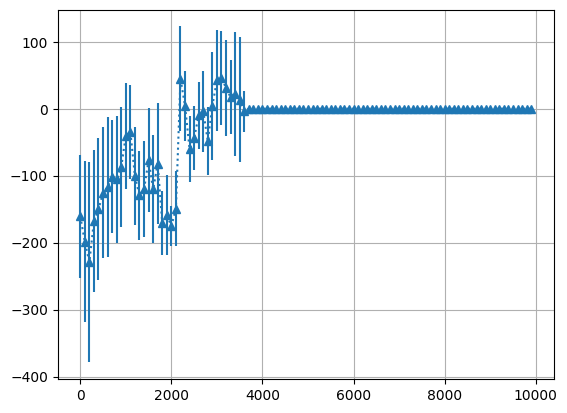

In [20]:
episodes = np.arange(1, 1+returns.size, returns.shape[1])
avg = np.mean(returns, axis=1)
std = np.std(returns, axis=1)
plt.errorbar(episodes, avg, std, linestyle=':', marker='^')
plt.grid()

経験分布関数についても確認しておきましょう．

In [ ]:
return_array = np.zeros(50)
for i in range(len(return_array)):
    history, img = rollout(envname, policy=agent2, render=False)
    return_array[i] = cumulative_reward(history)

fig, ax = plt.subplots()
sns.ecdfplot(data=-return_array, ax=ax)
ax.set_xlim(-400, 400)
plt.grid()

学習結果の確認は以下のコードで行います．

In [ ]:
history, img = rollout(envname, policy=agent2, render=True)
print(cumulative_reward(history))
visualize(img)

# 自習課題

* 方策を変えてみましょう．特に，中間層のノード数を変更した場合に，学習効率がどの程度変わるのか，グラフを作成するなどして確認しましょう．

* 学習率を調整してみましょう．特に，ベースラインを導入したREINFORCEでは，Actorの学習率とCriticの学習率について，効率的なパラメータの関係を確認してみましょう．

* タスクを変えてみましょう．タスクが異なれば，適切な方策（ノード数など）や適切な学習率も変化する可能性があります．これを確認してみましょう．